In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report, roc_auc_score)
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
attributes_df = pd.read_csv("scoutium_attributes.csv", sep=";")
potential_labels_df = pd.read_csv("scoutium_potential_labels.csv", sep=";")

In [4]:
attributes_df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value
0,4915,62935,177676,1361061,2,12818495,4322,56.0
1,4915,62935,177676,1361061,2,12818495,4323,56.0
2,4915,62935,177676,1361061,2,12818495,4324,67.0
3,4915,62935,177676,1361061,2,12818495,4325,56.0
4,4915,62935,177676,1361061,2,12818495,4326,45.0


In [5]:
potential_labels_df.head()

,task_response_id,match_id,evaluator_id,player_id,potential_label
0,4915,62935,177676,1361061,average
1,4915,62935,177676,1361626,highlighted
2,4915,62935,177676,1361858,average
3,4915,62935,177676,1362220,highlighted
4,4915,62935,177676,1364951,highlighted


In [6]:
# Veri birleştirme
df = attributes_df.merge(potential_labels_df, how="left", on=["task_response_id", "match_id", "evaluator_id", "player_id"])

In [8]:
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.0,average
1,4915,62935,177676,1361061,2,12818495,4323,56.0,average
2,4915,62935,177676,1361061,2,12818495,4324,67.0,average
3,4915,62935,177676,1361061,2,12818495,4325,56.0,average
4,4915,62935,177676,1361061,2,12818495,4326,45.0,average


In [9]:
df.shape

(10730, 9)

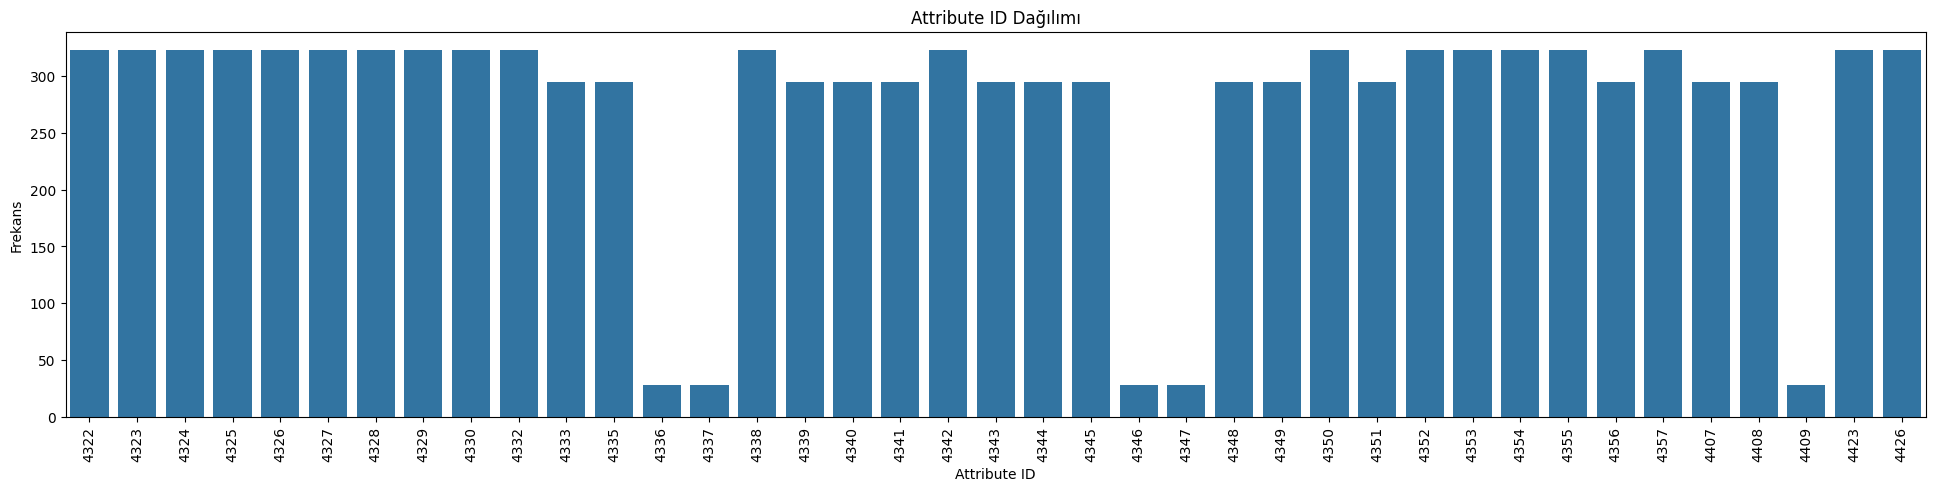

In [10]:
plt.figure(figsize=(24,5))
sns.countplot(x='attribute_id', data=attributes_df)
plt.title("Attribute ID Dağılımı")
plt.xlabel("Attribute ID")
plt.ylabel("Frekans")
plt.xticks(rotation=90)
plt.show()

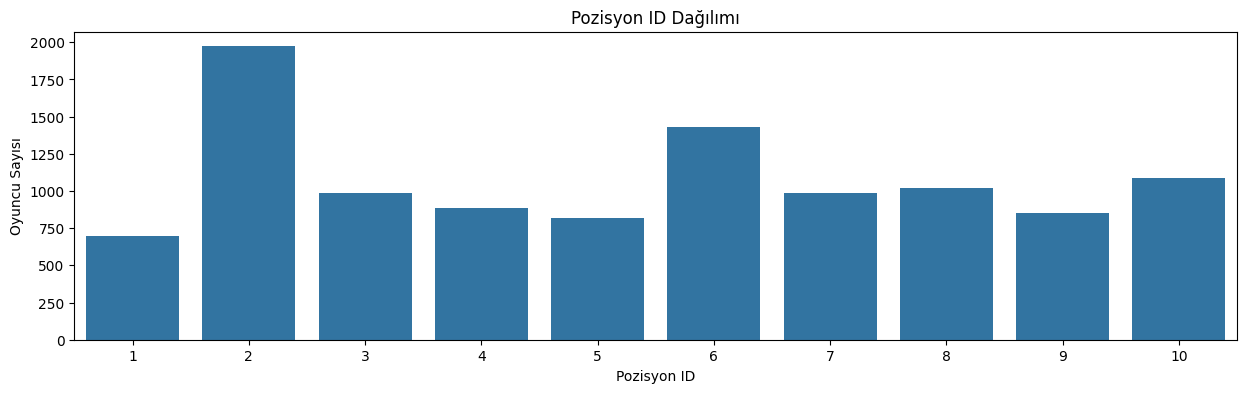

In [11]:
plt.figure(figsize=(15,4))
sns.countplot(x='position_id', data=attributes_df)
plt.title("Pozisyon ID Dağılımı")
plt.xlabel("Pozisyon ID")
plt.ylabel("Oyuncu Sayısı")
plt.show()

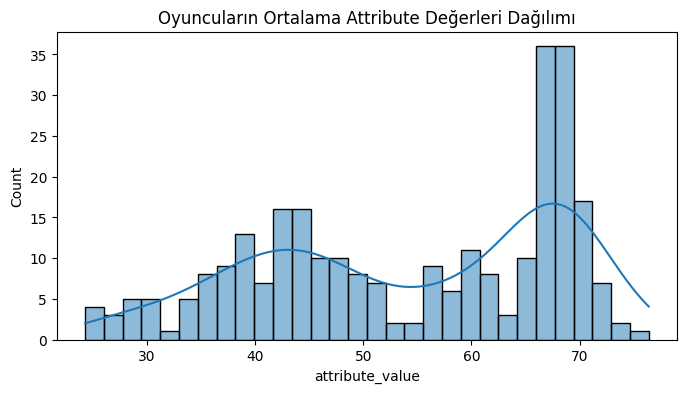

In [12]:
plt.figure(figsize=(8,4))
sns.histplot(df.groupby('player_id')['attribute_value'].mean(), bins=30, kde=True)
plt.title("Oyuncuların Ortalama Attribute Değerleri Dağılımı")
plt.show()

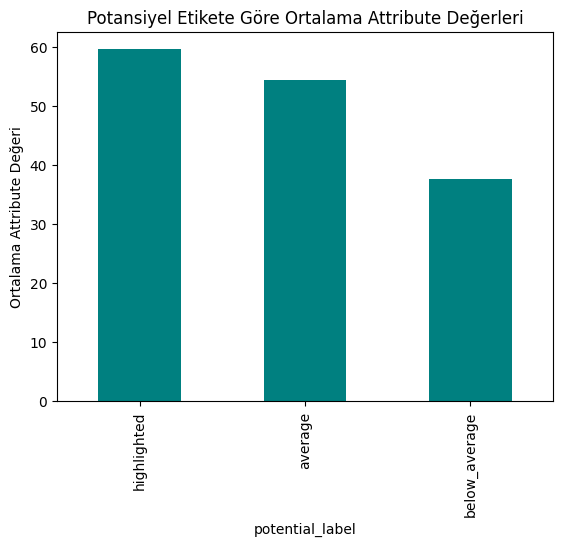

In [13]:
df.groupby('potential_label')['attribute_value'].mean().sort_values(ascending=False).plot(kind='bar', color='teal')
plt.title("Potansiyel Etikete Göre Ortalama Attribute Değerleri")
plt.ylabel("Ortalama Attribute Değeri")
plt.show()

In [14]:
df["task_response_id"].value_counts()

task_response_id
5440    458
5035    433
4970    433
4915    433
5156    399
5259    399
5314    399
5639    399
5621    374
4935    365
4931    365
4919    365
4929    365
5523    365
5465    365
5524    365
5119    365
4997    365
5036    365
5162    365
5319    365
5587    365
5579    365
5618    365
5527    365
5642    365
5003    331
5005    297
5006    170
Name: count, dtype: int64

In [15]:
df["evaluator_id"].value_counts()

evaluator_id
151191    3693
256441    2215
177676    1163
160289     832
132337     798
141254     501
130478     399
135624     399
186987     365
173255     365
Name: count, dtype: int64

In [16]:
df["match_id"].value_counts()

match_id
62935    798
62988    798
63166    798
63627    798
63032    764
63696    764
63556    739
62944    730
63406    730
64045    730
63058    696
63061    467
63930    458
60549    365
63862    365
63178    365
61923    365
Name: count, dtype: int64

In [17]:
df = df[df["position_id"] != 1] #kalecileri cıkar

In [18]:
# Below average etiketini çıkar
df = df[df["potential_label"] != "below_average"]

In [19]:
df["potential_label"].value_counts()

potential_label
average        7922
highlighted    1972
Name: count, dtype: int64

In [20]:
# Pivot table oluştur
scoutium_pivot = df.pivot_table(index=["player_id", "position_id", "potential_label"],
                                columns="attribute_id",
                                values="attribute_value")

In [21]:
scoutium_pivot.head()

attribute_id                           4322  4323  4324  4325  4326  4327  \
player_id position_id potential_label                                       
1355710   7           average          50.5  50.5  34.0  50.5  45.0  45.0   
1356362   9           average          67.0  67.0  67.0  67.0  67.0  67.0   
1356375   3           average          67.0  67.0  67.0  67.0  67.0  67.0   
          4           average          67.0  78.0  67.0  67.0  67.0  78.0   
1356411   9           average          67.0  67.0  78.0  78.0  67.0  67.0   

attribute_id                           4328  4329  4330  4332  ...  4352  \
player_id position_id potential_label                          ...         
1355710   7           average          45.0  45.0  50.5  56.0  ...  56.0   
1356362   9           average          67.0  67.0  67.0  67.0  ...  67.0   
1356375   3           average          67.0  78.0  67.0  67.0  ...  67.0   
          4           average          78.0  78.0  56.0  67.0  ...  78.0   
1356411   9           average          67.0  67.0  89.0  78.0  ...  67.0   

attribute_id                           4353  4354  4355  4356  4357  4407  \
player_id position_id potential_label                                       
1355710   7           average          34.0  39.5  50.5  34.0  34.0  56.0   
1356362   9           average          67.0  78.0  67.0  67.0  67.0  67.0   
1356375   3           average          67.0  78.0  67.0  67.0  67.0  67.0   
          4           average          67.0  67.0  67.0  56.0  67.0  56.0   
1356411   9           average          56.0  67.0  67.0  56.0  67.0  89.0   

attribute_id                           4408  4423  4426  
player_id position_id potential_label                    
1355710   7           average          34.0  34.0  56.0  
1356362   9           average          67.0  56.0  78.0  
1356375   3           average          67.0  56.0  78.0  
          4           average          67.0  45.0  56.0  
1356411   9           average          56.0  67.0  78.0  

[5 rows x 34 columns]

In [22]:
scoutium_pivot.shape

(271, 34)

In [23]:
scoutium_pivot.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 271 entries, (np.int64(1355710), np.int64(7), 'average') to (np.int64(1909728), np.int64(7), 'highlighted')
Data columns (total 34 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   4322    271 non-null    float64
 1   4323    271 non-null    float64
 2   4324    271 non-null    float64
 3   4325    271 non-null    float64
 4   4326    271 non-null    float64
 5   4327    271 non-null    float64
 6   4328    271 non-null    float64
 7   4329    271 non-null    float64
 8   4330    271 non-null    float64
 9   4332    271 non-null    float64
 10  4333    271 non-null    float64
 11  4335    271 non-null    float64
 12  4338    271 non-null    float64
 13  4339    271 non-null    float64
 14  4340    271 non-null    float64
 15  4341    271 non-null    float64
 16  4342    271 non-null    float64
 17  4343    271 non-null    float64
 18  4344    271 non-null    float64
 19  4345    271 non-null    flo

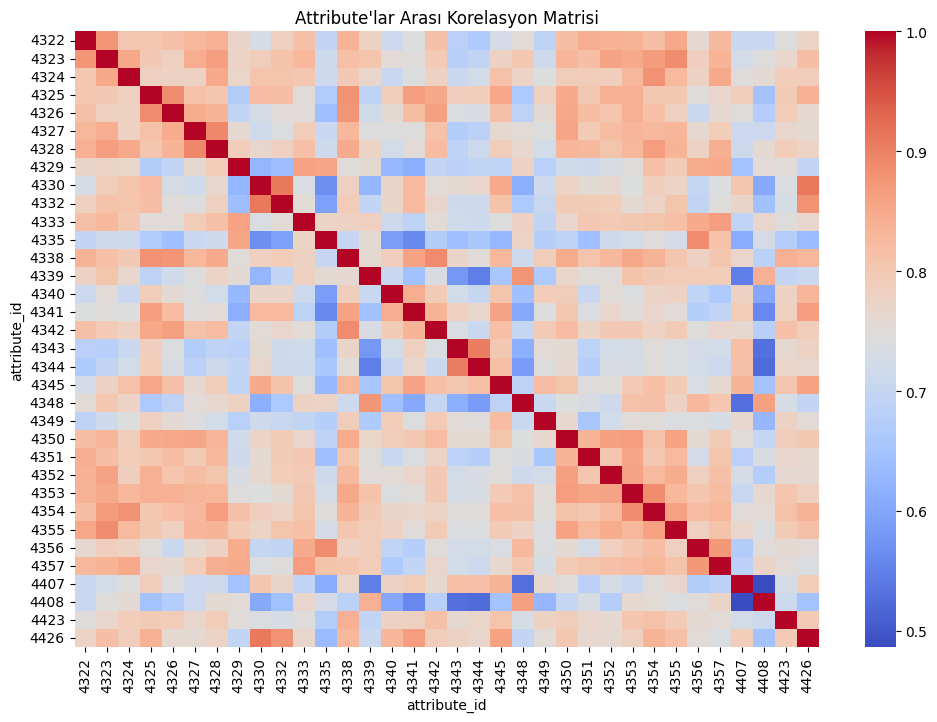

In [24]:
plt.figure(figsize=(12,8))
sns.heatmap(scoutium_pivot.corr(), cmap='coolwarm')
plt.title("Attribute'lar Arası Korelasyon Matrisi")
plt.show()

In [25]:
# Index'i reset et
scoutium_pivot = scoutium_pivot.reset_index()
scoutium_pivot.columns = scoutium_pivot.columns.astype(str)

In [26]:
scoutium_pivot.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.5,50.5,34.0,50.5,45.0,45.0,45.0,...,56.0,34.0,39.5,50.5,34.0,34.0,56.0,34.0,34.0,56.0
1,1356362,9,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
2,1356375,3,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
3,1356375,4,average,67.0,78.0,67.0,67.0,67.0,78.0,78.0,...,78.0,67.0,67.0,67.0,56.0,67.0,56.0,67.0,45.0,56.0
4,1356411,9,average,67.0,67.0,78.0,78.0,67.0,67.0,67.0,...,67.0,56.0,67.0,67.0,56.0,67.0,89.0,56.0,67.0,78.0


In [27]:
le = LabelEncoder()
scoutium_pivot["potential_label"] = le.fit_transform(scoutium_pivot["potential_label"])

In [28]:
scoutium_pivot.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,50.5,50.5,34.0,50.5,45.0,45.0,45.0,...,56.0,34.0,39.5,50.5,34.0,34.0,56.0,34.0,34.0,56.0
1,1356362,9,0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
2,1356375,3,0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
3,1356375,4,0,67.0,78.0,67.0,67.0,67.0,78.0,78.0,...,78.0,67.0,67.0,67.0,56.0,67.0,56.0,67.0,45.0,56.0
4,1356411,9,0,67.0,67.0,78.0,78.0,67.0,67.0,67.0,...,67.0,56.0,67.0,67.0,56.0,67.0,89.0,56.0,67.0,78.0


In [29]:
X = scoutium_pivot.drop(["potential_label", "player_id"], axis=1)
y = scoutium_pivot["potential_label"]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [31]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [32]:
X_train.head()

attribute_id,position_id,4322,4323,4324,4325,4326,4327,4328,4329,4330,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,-0.938434,-0.185323,-0.951910,-1.398616,-0.814967,-1.511352,-0.798752,-0.907087,-1.405470,-0.866592,...,-0.768209,-1.280062,-0.814368,-0.142751,-1.265993,-0.761080,-0.158928,-0.768707,-0.963433,-0.260472
1,-1.315905,-0.185323,-0.951910,-0.711502,-0.814967,-0.020703,-2.300104,-0.907087,-0.206333,-0.056272,...,-0.768209,0.106449,-0.196078,-1.628738,-1.265993,0.005322,-1.518469,-0.768707,-0.963433,-0.260472
2,0.193978,1.330003,0.543454,1.349839,0.697126,0.724621,0.702600,0.605892,0.992804,0.754048,...,0.808352,0.799705,1.040502,0.600242,0.933373,0.771724,1.200613,0.648426,1.053706,1.042895
3,1.703861,1.330003,2.038819,1.349839,0.697126,0.724621,1.453277,1.362382,0.992804,1.564367,...,0.808352,0.799705,1.040502,1.343236,0.200251,1.538126,1.880384,-1.477274,0.381326,1.042895
4,-0.938434,-1.700650,-2.447275,-2.085730,-1.571013,-1.511352,-2.300104,-1.663577,-1.405470,-1.676912,...,-3.133050,-2.666574,-2.669239,-3.114724,-1.265993,-0.761080,-3.557781,-1.477274,-1.635812,-1.563840


In [33]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

  File "C:\Users\samet\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\samet\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\samet\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\samet\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [34]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, class_weight='balanced', n_jobs=-1)
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_jobs=-1,
                       random_state=42)

In [35]:
y_pred = rfc.predict(X_test)

print(f'Random Forest Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print("\n", confusion_matrix(y_test, y_pred))
print("\n", classification_report(y_test, y_pred, target_names=['average', 'highlighted']))

Random Forest Accuracy: 0.9273

 [[43  1]
 [ 3  8]]

               precision    recall  f1-score   support

     average       0.93      0.98      0.96        44
 highlighted       0.89      0.73      0.80        11

    accuracy                           0.93        55
   macro avg       0.91      0.85      0.88        55
weighted avg       0.93      0.93      0.92        55



In [36]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rfc.feature_importances_
}).sort_values(by="importance", ascending=False)

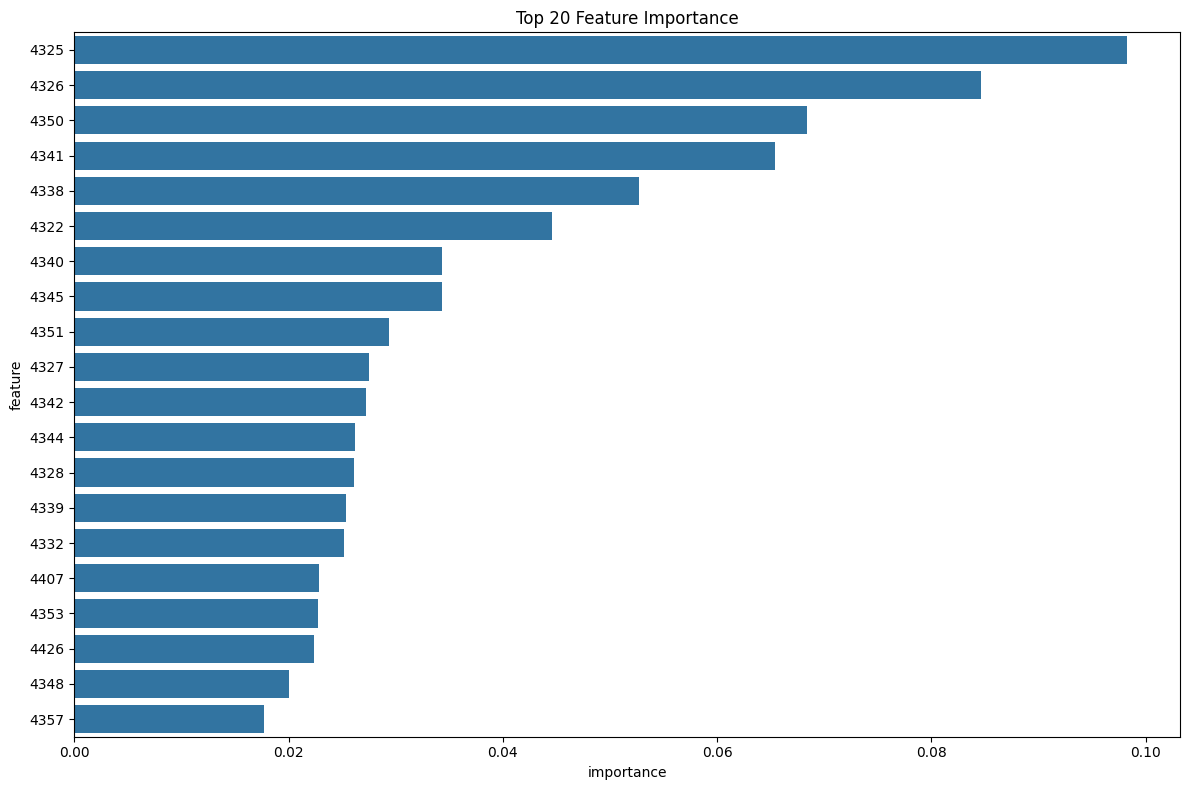

In [37]:
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title("Top 20 Feature Importance")
plt.tight_layout()
plt.show()

In [38]:
# Hyperparameter Tuning
rf_params = {
    "max_depth": [10, 15, 20, None],
    "max_features": [5, 7, 10, 'sqrt'],
    "min_samples_split": [2, 5, 10],
    "n_estimators": [100, 200, 300]
}

In [39]:
rfc_tuned = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rfc_tuned, rf_params, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                          scoring='f1_weighted', n_jobs=-1, verbose=1)

In [40]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20, None],
                         'max_features': [5, 7, 10, 'sqrt'],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1_weighted', verbose=1)

In [41]:
grid_search.best_params_

{'max_depth': 10,
 'max_features': 5,
 'min_samples_split': 2,
 'n_estimators': 100}

In [42]:
y_pred_tuned = grid_search.predict(X_test)

print(f'Tuned Model Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}')
print("\n", confusion_matrix(y_test, y_pred_tuned))
print("\n", classification_report(y_test, y_pred_tuned, target_names=['average', 'highlighted']))

Tuned Model Accuracy: 0.9091

 [[43  1]
 [ 4  7]]

               precision    recall  f1-score   support

     average       0.91      0.98      0.95        44
 highlighted       0.88      0.64      0.74        11

    accuracy                           0.91        55
   macro avg       0.89      0.81      0.84        55
weighted avg       0.91      0.91      0.90        55

